# KNN

## Curso "Introducción al Aprendizaje Automático"
## Facultad de Ingeniería
## UdelaR

K-Nearest Neighbors (KNN) es un modelo sencillo e intuitivo de aprendizaje supervisado. Clasifica una instancia nueva observando a qué clase pertenecen sus k vecinos más cercanos en el conjunto de entrenamiento, asumiendo que los ejemplos similares tienden a compartir la misma etiqueta.

In [1]:
%pylab inline
import IPython
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


print('IPython version:', IPython.__version__)
print('numpy version:', np.__version__)
print('scikit-learn version:', sk.__version__)
print('pandas version:', pd.__version__)
print('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
IPython version: 7.34.0
numpy version: 2.0.2
scikit-learn version: 1.6.1
pandas version: 2.2.2
matplotlib version: 3.10.0


# Importar el dataset

Vamos a usar el dataset con personajes de los Simpsons que usamos en el practico pasado, similar al que vimos en clase. Son datos sinteticos, de manera que puede contener errores.


La siguiente celda puede que no ejecute bien si corren localmente. Pueden descargar el archivo manualmente desde [este enlace](https://docs.google.com/spreadsheets/d/1nmBmgnPlkSyx8nsRKQAnBtkjIqIjEPTmxiX0dMvEADE/edit?usp=sharing)

In [2]:
dataset_url ="https://drive.google.com/file/d/1mvvP2S0ltwFHOwluGn-zha2Ga3Kn3bPv/view?usp=sharing"

!pip install -q gdown

import gdown


# Use gdown to download
gdown.download(dataset_url, output=None, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1mvvP2S0ltwFHOwluGn-zha2Ga3Kn3bPv
To: /content/toy_dataset.csv
100%|██████████| 9.95k/9.95k [00:00<00:00, 15.3MB/s]


'toy_dataset.csv'

La siguiente celda la ejecutamos para validar que el archivo este en el lugar adecuado:

In [3]:
import os

# assert <condicion que deberia cumplirse>, "mensaje de error si la condicion anterior falla"
assert os.path.exists("toy_dataset.csv"), "El archivo no existe"

Leemos el csv, para esto vamos a usar `Pandas`: es una gran biblioteca para analisis de datos, no vamos a profundizar demasiado en ella en el curso.

In [4]:
import pandas as pd

df = pd.read_csv("toy_dataset.csv")  # df es un DataFrame, muy similar a los de R

Cargamos todas las features que desarrollamos la clase pasada, y separamos en train/testustilizando los mismos parametros:

_Nota: si uds desarrollaron alguna más que quieran agregar, pueden hacerlo!_

In [5]:
from sklearn.model_selection import train_test_split
# dejamos libre el # de columnas a mostraren un DataFrame, para verlas todas
pd.set_option('display.max_columns', None)

# Casteamos features booleanas
def str_to_bool(x):
  return x.strip().lower() != "no"

boolean_features = ['Tiene barba', 'Tiene bigote', 'Usa collar', 'Usa lentes', 'Usa caravanas', 'Usa corbata', 'Usa moño','Usa chupete', 'Es fumador']
target = "Personaje principal"

for c in boolean_features + [target]:
  df[c] = df[c].apply(str_to_bool)

# Agreagamos todas las features que se calcular a partir solamente de la instancia
def se_apellida_simpson(nombre):
  return "simpson" in nombre.lower()

df["apellido_simpson"] = df["Nombre"].apply(se_apellida_simpson)
# Creamos una nueva columna: para cada fila, calculamos el cociente entre las apariciones en especiales y las apariciones totales
df["ratio_especiales"] = df["Apariciones en especiales"] / (df["Apariciones"]+1e-7)
df["tiene_vello_facial"] = (df["Tiene bigote"] | df["Tiene barba"])
df["aparece_mas_de_30"] = df["Apariciones"] > 30
df["ultimo_episodio"] = df["Primer episodio"] + df["Apariciones"]

# Partimos el dataset en train/test
X = df.drop("Personaje principal", axis=1)
y = df["Personaje principal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

max_apariciones = X_train["Apariciones"].max()
X_train["apariciones_normalizadas"] =  X_train["Apariciones"] / max_apariciones
X_test["apariciones_normalizadas"] =  X_test["Apariciones"] / max_apariciones

max_1er_ep = X_train["Primer episodio"].max()
X_train["1er_ep_normalizado"] =  X_train["Primer episodio"] / max_1er_ep
X_test["1er_ep_normalizado"] =  X_test["Primer episodio"] / max_1er_ep

# calculamos las apariciones_por_episodio (ex "feature cinco")
ultimo_episodio = X_train["ultimo_episodio"].max() #
X_train["apariciones_por_episodio"] = X_train["Apariciones"] / (ultimo_episodio + 1 - X_train["Primer episodio"])
X_test["apariciones_por_episodio"] = X_test["Apariciones"] / (ultimo_episodio + 1 - X_test["Primer episodio"])


X_train.head()

Nombre       Sexo  Edad  Grupo Etario   Pelo Color de piel  \
29              Gary  Masculino    21         Joven  Corto  Marrón claro   
81   The Sea Captain  Masculino    60  Adulto mayor  Largo        Blanco   
41      Judge Snyder  Masculino    58  Adulto mayor  Corto        Blanco   
75      Rod Flanders  Masculino     8         Joven  Corto        Blanco   
72  Reverend Lovejoy  Masculino    50        Adulto  Corto        Blanco   

   Color de pelo  Tiene barba  Tiene bigote  Usa collar  Usa lentes  \
29         Negro        False         False       False        True   
81          Gris         True         False       False       False   
41          Gris        False          True       False       False   
75         Rubio        False         False       False       False   
72          Gris         True          True       False       False   

    Usa caravanas  Usa corbata  Usa moño  Usa chupete  Es fumador  \
29          False        False     False        False       False   
81          False        False     False        False       False   
41          False         True     False        False       False   
75          False        False     False        False       False   
72          False         True     False        False       False   

   Ocupación principal  Primer episodio  Apariciones  \
29          Estudiante               84            6   
81    Capitán de barco              121          150   
41                Juez                1           50   
75          Estudiante                1           50   
72  Ministro religioso                1          150   

    Apariciones en especiales  apellido_simpson  ratio_especiales  \
29                          0             False          0.000000   
81                          3             False          0.020000   
41                          1             False          0.020000   
75                          1             False          0.020000   
72                          2             False          0.013333   

    tiene_vello_facial  aparece_mas_de_30  ultimo_episodio  \
29               False              False               90   
81                True               True              271   
41                True               True               51   
75               False               True               51   
72                True               True              151   

    apariciones_normalizadas  1er_ep_normalizado  apariciones_por_episodio  
29                  0.007595             0.10500                  0.008368  
81                  0.189873             0.15125                  0.220588  
41                  0.063291             0.00125                  0.062500  
75                  0.063291             0.00125                  0.062500  
72                  0.189873             0.00125                  0.187500

Agregamos el encoding de las features ordinales y one-hot:

In [6]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

categorical_features = ['Sexo', 'Pelo', 'Color de piel',
                          'Color de pelo']


numerical_features = ['Edad', 'Tiene barba', 'Tiene bigote', 'Usa collar',
                        'Usa lentes', 'Usa caravanas', 'Usa corbata', 'Usa moño',
                        'Usa chupete','Es fumador', 'Primer episodio', 'Apariciones',
                        'Apariciones en especiales', 'apellido_simpson',
                        'ratio_especiales',
       'tiene_vello_facial', 'aparece_mas_de_30', 'ultimo_episodio',
       'apariciones_normalizadas', '1er_ep_normalizado',
       'apariciones_por_episodio']

ordinal_features = ['Grupo Etario']



# Aplicar One-Hot Encoding a las características categóricas
# Creamos una instancia del OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Entrenamos el encoder con los datos de entrenamiento
ohe_encoder.fit(X_train[categorical_features])

# Transformamos los datos de entrenamiento y prueba
X_train_categorical_encoded = ohe_encoder.transform(X_train[categorical_features])
X_test_categorical_encoded = ohe_encoder.transform(X_test[categorical_features])


# Initialize the OrdinalEncoder with the specified order
oe = OrdinalEncoder(categories=[['Joven','Adulto', 'Adulto mayor']],
                    handle_unknown="use_encoded_value",unknown_value=-1)

X_train_ordinal = oe.fit_transform(X_train[ordinal_features])
X_test_ordinal = oe.transform(X_test[ordinal_features])

# Obtenemos los nombres de las nuevas columnas creadas por el OneHotEncoder
new_categorical_feature_names = ohe_encoder.get_feature_names_out(categorical_features)

# Creamos DataFrames con las características categóricas codificadas
X_train_categorical_df = pd.DataFrame(X_train_categorical_encoded,
                                      columns=new_categorical_feature_names,
                                      index=X_train.index)
X_test_categorical_df = pd.DataFrame(X_test_categorical_encoded,
                                     columns=new_categorical_feature_names,
                                     index=X_test.index)

X_train_ordinal = pd.DataFrame(X_train_ordinal, columns=['grupo etario_encoded'], index=X_train.index)
X_test_ordinal = pd.DataFrame(X_test_ordinal, columns=['grupo etario_encoded'], index=X_test.index)

# Concatenamos las características numéricas originales con las categóricas codificadas
X_train_processed = pd.concat([X_train[numerical_features], X_train_categorical_df, X_train_ordinal], axis=1)
X_test_processed = pd.concat([X_test[numerical_features], X_test_categorical_df, X_test_ordinal], axis=1)


A partir de acá, vamos a trabajar con `X_train_processed`y `X_test_processed`, que contiene los mismos datos de la clase pasada:

In [7]:
X_train_processed.shape, X_test_processed.shape

((70, 42), (18, 42))

Comencemos por ver las correlacioenes que tenemos entre nuestras columnas

In [10]:

X_train_processed.columns

Index(['Edad', 'Tiene barba', 'Tiene bigote', 'Usa collar', 'Usa lentes',
       'Usa caravanas', 'Usa corbata', 'Usa moño', 'Usa chupete', 'Es fumador',
       'Primer episodio', 'Apariciones', 'Apariciones en especiales',
       'apellido_simpson', 'ratio_especiales', 'tiene_vello_facial',
       'aparece_mas_de_30', 'ultimo_episodio', 'apariciones_normalizadas',
       '1er_ep_normalizado', 'apariciones_por_episodio', 'Sexo_Femenino',
       'Sexo_Masculino', 'Pelo_Calvo', 'Pelo_Corto', 'Pelo_Largo',
       'Color de piel_Amarillo', 'Color de piel_Blanco',
       'Color de piel_Latina', 'Color de piel_Marrón',
       'Color de piel_Marrón claro', 'Color de pelo_Amarillo',
       'Color de pelo_Azul', 'Color de pelo_Blanco', 'Color de pelo_Castaño',
       'Color de pelo_Gris', 'Color de pelo_Marrón', 'Color de pelo_Naranja',
       'Color de pelo_Negro', 'Color de pelo_Rubio', 'Color de pelo_Verde',
       'grupo etario_encoded'],
      dtype='object')

In [17]:
pd.concat([y_train, X_train_processed], axis=1).corr('pearson')#[["aparece_mas_de_30", "apariciones_normalizadas", "Apariciones", "apariciones_por_episodio"] ]

Personaje principal      Edad  Tiene barba  \
Personaje principal                    1.000000 -0.056729     0.026034   
Edad                                  -0.056729  1.000000     0.369068   
Tiene barba                            0.026034  0.369068     1.000000   
Tiene bigote                           0.230112  0.225597     0.252748   
Usa collar                             0.020560 -0.089006    -0.044251   
Usa lentes                             0.064130  0.096968     0.075193   
Usa caravanas                         -0.039686  0.028486     0.021026   
Usa corbata                            0.150232  0.270021     0.165010   
Usa moño                               0.009816  0.090713    -0.078008   
Usa chupete                            0.127473 -0.186704    -0.054759   
Es fumador                             0.142667  0.027818     0.011903   
Primer episodio                       -0.169009 -0.039772     0.139645   
Apariciones                            0.502045  0.003965     0.127833   
Apariciones en especiales              0.512223 -0.049274     0.009326   
apellido_simpson                       0.119754 -0.087005     0.266937   
ratio_especiales                      -0.180841 -0.171174    -0.092800   
tiene_vello_facial                     0.222217  0.368154     0.629724   
aparece_mas_de_30                      0.512077  0.034314     0.021918   
ultimo_episodio                        0.376781 -0.020879     0.209308   
apariciones_normalizadas               0.502045  0.003965     0.127833   
1er_ep_normalizado                    -0.169009 -0.039772     0.139645   
apariciones_por_episodio               0.510281  0.006140     0.133362   
Sexo_Femenino                         -0.173303  0.107970    -0.157325   
Sexo_Masculino                         0.173303 -0.107970     0.157325   
Pelo_Calvo                            -0.039686  0.299102     0.315388   
Pelo_Corto                             0.114473 -0.191109    -0.246382   
Pelo_Largo                            -0.106261 -0.001753     0.051768   
Color de piel_Amarillo                -0.116156 -0.269791    -0.138680   
Color de piel_Blanco                   0.165227  0.349860     0.218844   
Color de piel_Latina                  -0.113692 -0.001236    -0.054759   
Color de piel_Marrón                   0.014091 -0.103668    -0.111979   
Color de piel_Marrón claro            -0.113692 -0.118700    -0.054759   
Color de pelo_Amarillo                 0.352958 -0.233293     0.101080   
Color de pelo_Azul                     0.127473 -0.186704    -0.054759   
Color de pelo_Blanco                  -0.161963 -0.023779    -0.078008   
Color de pelo_Castaño                  0.137722 -0.003018    -0.119753   
Color de pelo_Gris                    -0.125951  0.495246     0.319032   
Color de pelo_Marrón                   0.009816 -0.107447    -0.078008   
Color de pelo_Naranja                 -0.113692 -0.063059    -0.054759   
Color de pelo_Negro                   -0.074727 -0.105487    -0.052787   
Color de pelo_Rubio                   -0.191759 -0.179283    -0.174716   
Color de pelo_Verde                    0.127473  0.048222    -0.054759   
grupo etario_encoded                  -0.093179  0.895710     0.380534   

                            Tiene bigote  Usa collar  Usa lentes  \
Personaje principal             0.230112    0.020560    0.064130   
Edad                            0.225597   -0.089006    0.096968   
Tiene barba                     0.252748   -0.044251    0.075193   
Tiene bigote                    1.000000   -0.211341   -0.028818   
Usa collar                     -0.211341    1.000000    0.059382   
Usa lentes                     -0.028818    0.059382    1.000000   
Usa caravanas                  -0.036262    0.423415    0.152831   
Usa corbata                     0.262261    0.130311    0.145810   
Usa moño                        0.095295   -0.061604    0.138603   
Usa chupete                    -0.070829   -0.043244   -0.057492   
Es fumador             

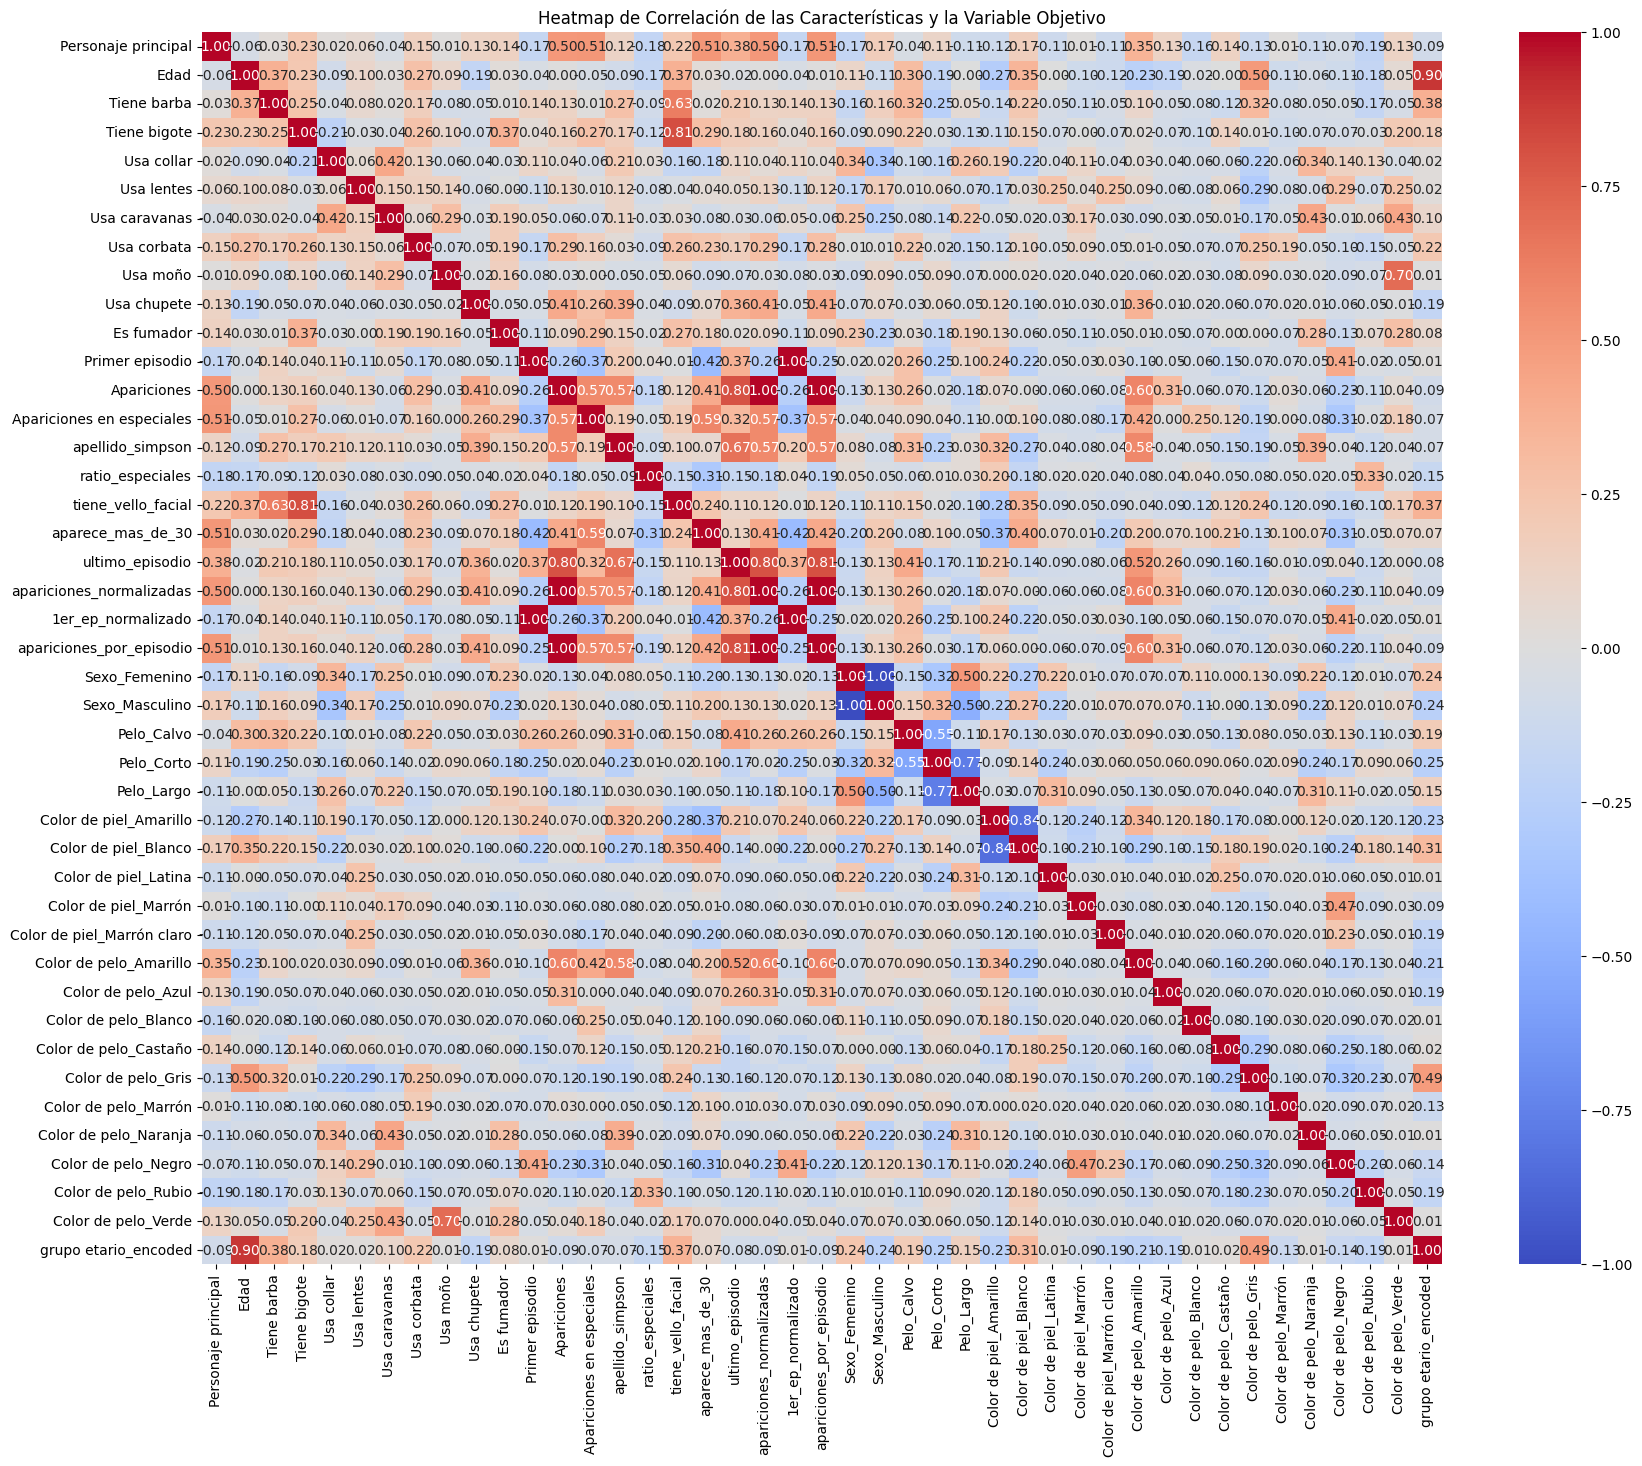

In [26]:
corr_matrix = pd.concat([y_train, X_train_processed], axis=1).corr('pearson')
plt.figure(figsize=(20, 16))
import seaborn as sns # Moved the import to the beginning of the cell
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlación de las Características y la Variable Objetivo')
plt.show()

## Ejercicio:
- Entre el target (`"Personaje principal"`) y `"Edad"` hay una correlación de `-0.056`: qué implica?
- La correlación entre las variables `Sexo_Masculino` y `Sexo_Femenino` vale -1, mientras que entre las variables `Pelo_corto` y `Pelo_calvo` es 0.114: a qué se debe?
- Qué variable es la más prometedora? Justifique brevemente
- Eliminaria alguna variable en este punto? Cual(es)? Justifique brevemente
- En clase mencionamos la heuristica que proponen [Duda et.al](https://books.google.com.uy/books/about/Pattern_Classification.html?id=YoxQAAAAMAAJ&source=kp_book_description&redir_esc=y): $N>=5 \times d$, donde $N$ es la cantidad de datos disponibles y $d$ las dimensiones de su representación. Cuántas columnas deberíamos seleccionar, como maximo, en este problema?


# Entrenar nuestro primer KNN

Comencemos por entrenar nuestro primer knn, usaremos todos los atributos y todos los parametros por defecto:

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train)

KNeighborsClassifier()

In [19]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 7 folds
cv_scores = cross_val_score(knn, X_train_processed, y_train, cv=7, scoring="f1")

print("Results with defaults:")
print(f"F-score: {cv_scores.mean():0.3f}±{cv_scores.std():0.3f}")

Results with defaults:
F-score: 0.755±0.088


## Normalizar

Veamos el efecto de normalizar. Para esto, normalizamos segun las dos estrategias que comentamos en clase: `MinMaxScaler, StandardScaler`.

Evaluaos cada una de ellas al usar knn con los parametros por defecto, y las evaluamos con valizacion cruzada, a ver cual resulta mejor:

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score

# MinMax Scaling
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_processed)
X_test_minmax = scaler_minmax.transform(X_test_processed)

# Standardization (Mean 0, Std 1)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_processed)
X_test_std = scaler_std.transform(X_test_processed)

# Train KNN with default parameters using MinMax Scaled data
knn_minmax = KNeighborsClassifier()
cv_scores_minmax = cross_val_score(knn_minmax, X_train_minmax, y_train, cv=7, scoring="f1")

print("Results with MinMax Scaling:")
print(f"F-score: {cv_scores_minmax.mean():0.3f}±{cv_scores_minmax.std():0.3f}")
print("-" * 20)

# Train KNN with default parameters using Standardized data
knn_std = KNeighborsClassifier()
cv_scores_std = cross_val_score(knn_std, X_train_std, y_train, cv=7, scoring="f1")

print("Results with Standardization:")
print(f"F-score: {cv_scores_std.mean():0.3f}±{cv_scores_std.std():0.3f}")

Results with MinMax Scaling:
F-score: 0.657±0.126
--------------------
Results with Standardization:
F-score: 0.678±0.083


## Ejercicio:
Replique el codigo de la celda anterior, pero, en vez de usar `KNNClassifier` utilice `DecisionTreeClassifier(criterion="entropy", random_state=0)`.

Que resultados observa? A que se debe?

_sugerencia: formulen una hipotesis de qué esperan que pasen antes de ejecutar el experimento_

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score

# MinMax Scaling
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_processed)
X_test_minmax = scaler_minmax.transform(X_test_processed)

# Standardization (Mean 0, Std 1)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_processed)
X_test_std = scaler_std.transform(X_test_processed)

# Train KNN with default parameters using MinMax Scaled data
knn_minmax = DecisionTreeClassifier(criterion="entropy", random_state=0)
cv_scores_minmax = cross_val_score(knn_minmax, X_train_minmax, y_train, cv=7, scoring="f1")

print("Results with MinMax Scaling:")
print(f"F-score: {cv_scores_minmax.mean():0.3f}±{cv_scores_minmax.std():0.3f}")
print("-" * 20)

# Train KNN with default parameters using Standardized data
knn_std = DecisionTreeClassifier(criterion="entropy", random_state=0)
cv_scores_std = cross_val_score(knn_std, X_train_std, y_train, cv=7, scoring="f1")

print("Results with Standardization:")
print(f"F-score: {cv_scores_std.mean():0.3f}±{cv_scores_std.std():0.3f}")

Results with MinMax Scaling:
F-score: 0.695±0.090
--------------------
Results with Standardization:
F-score: 0.695±0.090


Hipotesis: va a pasar que bla bla bla


# Feature selection

## SlectKBest
Probemos elegir las mejores 14 features, mirando unicamente la relacion lineal con el target:

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Usamos f_classif que mide la dependencia lineal entre features y el target
# Aunque no es correlación exacta, es una medida de la relación lineal.
# Seleccionamos las 14 mejores características
selector = SelectKBest(score_func=f_classif, k=14)

# Ajustamos el selector a los datos de entrenamiento y el target
selector.fit(X_train_processed, y_train)

# Obtenemos las columnas seleccionadas (indices booleanos)
selected_features_mask = selector.get_support()

# Obtenemos los nombres de las columnas seleccionadas
selected_feature_names = X_train_processed.columns[selected_features_mask]

# Transformamos los datos de entrenamiento y prueba para quedarnos solo con las features seleccionadas
X_train_selected_k = selector.transform(X_train_processed)
X_test_selected_k = selector.transform(X_test_processed)

print("Features seleccionadas:")
print(selected_feature_names)
print(X_train_processed.shape)
print("\nDimensiones de los datos de entrenamiento después de la selección:", X_train_selected_k.shape)
print("Dimensiones de los datos de prueba después de la selección:", X_test_selected_k.shape)

Features seleccionadas:
Index(['Tiene bigote', 'Apariciones', 'Apariciones en especiales',
       'ratio_especiales', 'tiene_vello_facial', 'aparece_mas_de_30',
       'ultimo_episodio', 'apariciones_normalizadas', '1er_ep_normalizado',
       'apariciones_por_episodio', 'Sexo_Femenino', 'Sexo_Masculino',
       'Color de pelo_Amarillo', 'Color de pelo_Rubio'],
      dtype='object')
(70, 42)

Dimensiones de los datos de entrenamiento después de la selección: (70, 14)
Dimensiones de los datos de prueba después de la selección: (18, 14)


## Ejercicio

Ven alguna desventaja o posibilidad de mejora en lo que acabamos de hacer?

In [25]:
knn_k_best = KNeighborsClassifier()
cv_scores_k_best = cross_val_score(knn_k_best, X_train_selected_k, y_train, cv=7, scoring="f1")

print("Results with 14 best:")
print(f"F-score: {cv_scores_k_best.mean():0.3f}±{cv_scores_k_best.std():0.3f}")

Results with 14 best:
F-score: 0.758±0.071


## RFE: Recursive Feature Elimination
Probemos otro criterio: tomar las 14 mejores pero siguiendo RFE. Como KNN no tiene implementado un `feature_importance_`, usemos un árbol para estimar la importancia de las features. Veamos luego su performance.


### Ejercicio:
Supongamos que busco entrenar un modelo que si tiene un feature_importance (ejemplo: un arbol). Deberia usarlo tambien para hacer la seleccion de atributos? Justifique brevemente


In [27]:
from sklearn.feature_selection import RFE

# Creamos un estimador base para RFE
# Usamos un DecisionTreeClassifier como estimador
estimator = DecisionTreeClassifier(random_state=42)

# Inicializamos RFE con el estimador y el número de features a seleccionar
# Seleccionamos las 14 mejores características
rfe = RFE(estimator=estimator, n_features_to_select=14)

# Ajustamos RFE a los datos de entrenamiento
# Esto realizará iterativamente la eliminación de features
rfe.fit(X_train_processed, y_train)

# Obtenemos las columnas seleccionadas (indices booleanos)
selected_features_mask_rfe = rfe.support_

# Obtenemos los nombres de las columnas seleccionadas por RFE
selected_feature_names_rfe = X_train_processed.columns[selected_features_mask_rfe]

# Transformamos los datos de entrenamiento y prueba para quedarnos solo con las features seleccionadas
X_train_selected_rfe = rfe.transform(X_train_processed)
X_test_selected_rfe = rfe.transform(X_test_processed)

print("Features seleccionadas por RFE:")
print(selected_feature_names_rfe)
print("\nDimensiones de los datos de entrenamiento después de RFE:", X_train_selected_rfe.shape)
print("Dimensiones de los datos de prueba después de RFE:", X_test_selected_rfe.shape)

# Evaluamos la performance con las features seleccionadas por RFE usando KNN
knn_rfe = KNeighborsClassifier()
cv_scores_rfe = cross_val_score(knn_rfe, X_train_selected_rfe, y_train, cv=7, scoring="f1")

print("\nResults with RFE (14 features):")
print(f"F-score: {cv_scores_rfe.mean():0.3f}±{cv_scores_rfe.std():0.3f}")

Features seleccionadas por RFE:
Index(['Edad', 'ratio_especiales', 'ultimo_episodio',
       'apariciones_por_episodio', 'Sexo_Femenino', 'Color de pelo_Blanco',
       'Color de pelo_Castaño', 'Color de pelo_Gris', 'Color de pelo_Marrón',
       'Color de pelo_Naranja', 'Color de pelo_Negro', 'Color de pelo_Rubio',
       'Color de pelo_Verde', 'grupo etario_encoded'],
      dtype='object')

Dimensiones de los datos de entrenamiento después de RFE: (70, 14)
Dimensiones de los datos de prueba después de RFE: (18, 14)

Results with RFE (14 features):
F-score: 0.781±0.109


In [28]:
selected_feature_names_rfe = set(selected_feature_names_rfe)
selected_feature_names =set(selected_feature_names)

print("Features seleccionadas:")
print(f"- por ambos: {selected_feature_names_rfe.intersection(selected_feature_names)}")
print(f"- solo por SelectKBest: {selected_feature_names.difference(selected_feature_names_rfe)}")
print(f"- solo por RFE: {selected_feature_names_rfe.difference(selected_feature_names)}")

Features seleccionadas:
- por ambos: {'ratio_especiales', 'Sexo_Femenino', 'ultimo_episodio', 'apariciones_por_episodio', 'Color de pelo_Rubio'}
- solo por SelectKBest: {'Color de pelo_Amarillo', 'Apariciones', '1er_ep_normalizado', 'Sexo_Masculino', 'Tiene bigote', 'tiene_vello_facial', 'Apariciones en especiales', 'aparece_mas_de_30', 'apariciones_normalizadas'}
- solo por RFE: {'Color de pelo_Negro', 'Color de pelo_Blanco', 'Color de pelo_Castaño', 'grupo etario_encoded', 'Color de pelo_Verde', 'Edad', 'Color de pelo_Gris', 'Color de pelo_Naranja', 'Color de pelo_Marrón'}


## Sequencial Feature Elimination
Probemos por ultimo utilizando SFE para tomar las mejores 14 features.

Para hacerlo de manera mas eficiente, deberiamos usar `forward` o `backward`? Justifique y modifique el parametro `direction='forward'` o, `direction='backward'` segun corresponda.



In [30]:
from sklearn.feature_selection import SequentialFeatureSelector
SequentialFeatureSelector?

In [31]:
from sklearn.feature_selection import SequentialFeatureSelector

# Inicializamos el estimador base (KNN en este caso)
estimator = KNeighborsClassifier()

# Inicializamos SequentialFeatureSelector
# n_features_to_select=14: seleccionamos las 14 mejores features
# direction='completar aca': usen el metodo que use menos computo ('forward', 'backward)
# cv=7: usamos 7-fold cross-validation para evaluar cada subset de features
# scoring='f1': usamos F1-score como métrica de evaluación
sfs = SequentialFeatureSelector(estimator=estimator,
                                n_features_to_select=14,
                                direction='forward',  # 'forward', 'backward
                                cv=7,
                                scoring='f1',
                                n_jobs=-1)

# Ajustamos el SFS a los datos de entrenamiento
# Esto realiza la selección de features secuencialmente
sfs.fit(X_train_processed, y_train)

# Obtenemos las columnas seleccionadas (indices booleanos)
selected_features_mask_sfs = sfs.get_support()

# Obtenemos los nombres de las columnas seleccionadas por SFS
selected_feature_names_sfs = X_train_processed.columns[selected_features_mask_sfs]

# Transformamos los datos de entrenamiento y prueba para quedarnos solo con las features seleccionadas
X_train_selected_sfs = sfs.transform(X_train_processed)
X_test_selected_sfs = sfs.transform(X_test_processed)

print("Features seleccionadas por SequentialFeatureSelector (forward):")
print(selected_feature_names_sfs)
print("\nDimensiones de los datos de entrenamiento después de SFS:", X_train_selected_sfs.shape)
print("Dimensiones de los datos de prueba después de SFS:", X_test_selected_sfs.shape)

# Evaluamos la performance con las features seleccionadas por SFS usando KNN
# Aunque SFS ya utiliza CV internamente para seleccionar las features,
# podemos evaluar el modelo final con CV en el conjunto seleccionado
knn_sfs = KNeighborsClassifier()
cv_scores_sfs = cross_val_score(knn_sfs, X_train_selected_sfs, y_train, cv=7, scoring="f1")

print("\nResults with SFS (14 features, forward):")
print(f"F-score: {cv_scores_sfs.mean():0.3f}±{cv_scores_sfs.std():0.3f}")


Features seleccionadas por SequentialFeatureSelector (forward):
Index(['Tiene bigote', 'Usa collar', 'Usa caravanas', 'Usa corbata',
       'Usa moño', 'Usa chupete', 'Apariciones', 'apellido_simpson',
       'ratio_especiales', 'tiene_vello_facial', 'aparece_mas_de_30',
       'apariciones_normalizadas', '1er_ep_normalizado',
       'Color de piel_Marrón'],
      dtype='object')

Dimensiones de los datos de entrenamiento después de SFS: (70, 14)
Dimensiones de los datos de prueba después de SFS: (18, 14)

Results with SFS (14 features, forward):
F-score: 0.826±0.079


## KNN hyperparams

Hasta ahora hemos dejados los hiperparametros de knn, y con eccos obtuvimos una forma de normalizar y seleccionar atributos que nos retrnan buenos resultados. Ahora podemos enfocarnos en mejorar los hiperparametros de knn.

Comencemos por vel el valor adecuado para K.

### Ejercicio:
- Qué pasa si k=1?
- Qué pasa si `k==len(X_train)`?

Justifique

Testing k from 1 to 10
k=1: F-score = 0.735 ± 0.164
k=2: F-score = 0.677 ± 0.195
k=3: F-score = 0.734 ± 0.143
k=4: F-score = 0.720 ± 0.153
k=5: F-score = 0.826 ± 0.079
k=6: F-score = 0.808 ± 0.109
k=7: F-score = 0.813 ± 0.075
k=8: F-score = 0.797 ± 0.064
k=9: F-score = 0.797 ± 0.064
k=10: F-score = 0.797 ± 0.064


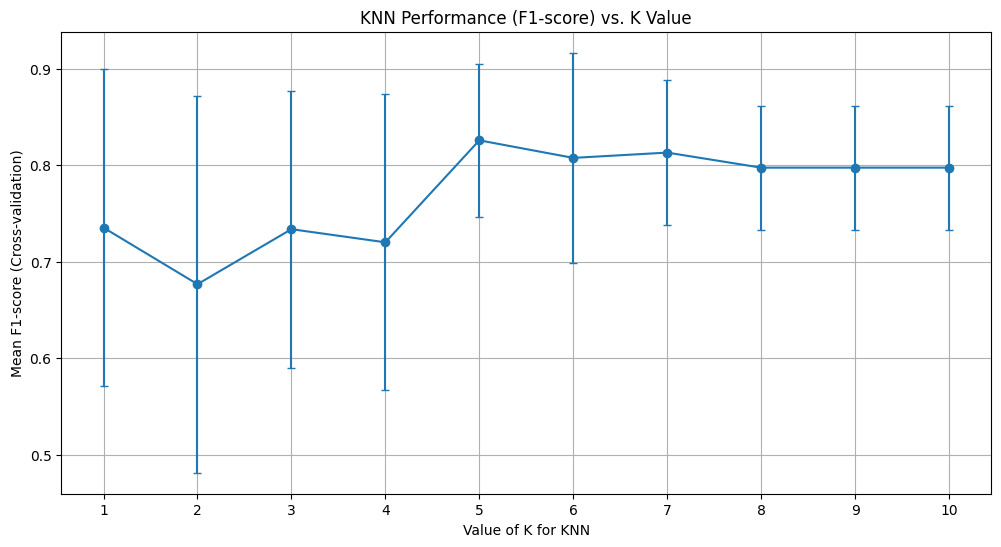

In [32]:
import matplotlib.pyplot as plt

# Determine the maximum value of k to test
max_k = int(len(X_train) / 7)
print(f"Testing k from 1 to {max_k}")

# Lists to store the results
k_values = []
mean_f1_scores = []
std_f1_scores = []

# Loop through k values from 1 to max_k
for k in range(1, max_k + 1):
  # Initialize KNN classifier with the current k
  knn = KNeighborsClassifier(n_neighbors=k)

  # Perform cross-validation with 7 folds
  cv_scores = cross_val_score(knn, X_train_selected_sfs, y_train, cv=7, scoring="f1", n_jobs=-1)

  # Store the results
  k_values.append(k)
  mean_f1_scores.append(cv_scores.mean())
  std_f1_scores.append(cv_scores.std())

  # Report f1 score for the current k
  print(f"k={k}: F-score = {cv_scores.mean():0.3f} ± {cv_scores.std():0.3f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.errorbar(k_values, mean_f1_scores, yerr=std_f1_scores, marker='o', linestyle='-', capsize=3)
plt.xlabel("Value of K for KNN")
plt.ylabel("Mean F1-score (Cross-validation)")
plt.title("KNN Performance (F1-score) vs. K Value")
plt.grid(True)
plt.xticks(k_values)
plt.show()


## Ejercicio:

Expanda la siguiente grilla de parametros para buscar los mejores.

_sugerencia: consultar la documentacion (`KNeighborsClassifier?`)_

In [33]:
KNeighborsClassifier?

In [37]:
sfs.get_feature_names_out()

array(['Tiene bigote', 'Usa collar', 'Usa caravanas', 'Usa corbata',
       'Usa moño', 'Usa chupete', 'Apariciones', 'apellido_simpson',
       'ratio_especiales', 'tiene_vello_facial', 'aparece_mas_de_30',
       'apariciones_normalizadas', '1er_ep_normalizado',
       'Color de piel_Marrón'], dtype=object)

In [40]:
from sklearn.model_selection import GridSearchCV


# Definimos los parámetros a probar en la Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 10],  #
    'weights': ['uniform', 'distance'],
    'metric': ['l1', 'l2', 'cosine']
}

# Creamos una instancia del clasificador KNN
knn = KNeighborsClassifier()

# Creamos una instancia de GridSearchCV
# estimator: el modelo a optimizar
# param_grid: el diccionario de parámetros a probar
# cv: número de folds para cross-validation
# scoring: la métrica a optimizar ('f1' para F1-score)
# n_jobs=-1: usa todos los núcleos disponibles
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=7,
                           scoring='f1',
                           n_jobs=-1)

# Ejecutamos la Grid Search en los datos de entrenamiento finales
grid_search.fit(X_train_selected_sfs, y_train)

# Obtenemos los mejores parámetros encontrados
best_params = grid_search.best_params_

# Obtenemos el mejor score (media de F1-score en cross-validation)
best_score = grid_search.best_score_

# Calculamos el error estándar de la mejor configuración (aproximación usando los resultados de CV)
# sklearn.model_selection.GridSearchCV.cv_results_['std_test_score'][grid_search.best_index_]
std_best_score = grid_search.cv_results_['std_test_score'][grid_search.best_index_]


print("\nResultados de la Grid Search:")
print("Mejores parámetros encontrados:")
print(best_params)
print("\nMejor score (Media F1-score en CV) con los mejores parámetros:")
print(f"F-score: {best_score:0.3f}±{std_best_score:0.3f}")


Resultados de la Grid Search:
Mejores parámetros encontrados:
{'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}

Mejor score (Media F1-score en CV) con los mejores parámetros:
F-score: 0.826±0.079


## Vecindario definido segun distancia

Vamos a usar `RadiusNeighborsClassifier`

### Ejercicio:
- Que sucede si utilizo un valor demasiado bajo del radio? (_pista: estamos usando el parametro `outer_label`, consultar en documentación_)
- Que sucede si utilizo un valor demasiado alto del radio?
- Ejecute la siguiente celda: cual es el valor óptimo de `radius`? Cuál es el valor máximo (aproximadamente) para `radius`? (_pista: modifiquen los valores dados para ver como cambia el comportamiento_)

In [41]:
from sklearn.neighbors import RadiusNeighborsClassifier
RadiusNeighborsClassifier?

Radius=100: F-score = 0.590 ± 0.124
Radius=150: F-score = 0.712 ± 0.142
Radius=200: F-score = 0.676 ± 0.172
Radius=250: F-score = 0.736 ± 0.092
Radius=300: F-score = 0.762 ± 0.064
Radius=350: F-score = 0.727 ± 0.131
Radius=400: F-score = 0.640 ± 0.154
Radius=450: F-score = 0.349 ± 0.296
Radius=500: F-score = 0.279 ± 0.277
Radius=550: F-score = 0.286 ± 0.278
Radius=600: F-score = 0.286 ± 0.278
Radius=650: F-score = 0.286 ± 0.278
Radius=700: F-score = 0.286 ± 0.278
Radius=750: F-score = 0.279 ± 0.277
Radius=800: F-score = 0.286 ± 0.278
Radius=850: F-score = 0.286 ± 0.278
Radius=900: F-score = 0.286 ± 0.278
Radius=950: F-score = 0.286 ± 0.278
Radius=1000: F-score = 0.286 ± 0.278
Radius=1050: F-score = 0.286 ± 0.278
Radius=1100: F-score = 0.286 ± 0.278
Radius=1150: F-score = 0.238 ± 0.294
Radius=1200: F-score = 0.238 ± 0.294
Radius=1250: F-score = 0.238 ± 0.294
Radius=1300: F-score = 0.200 ± 0.249
Radius=1350: F-score = 0.200 ± 0.249
Radius=1400: F-score = 0.200 ± 0.249
Radius=1450: F-scor

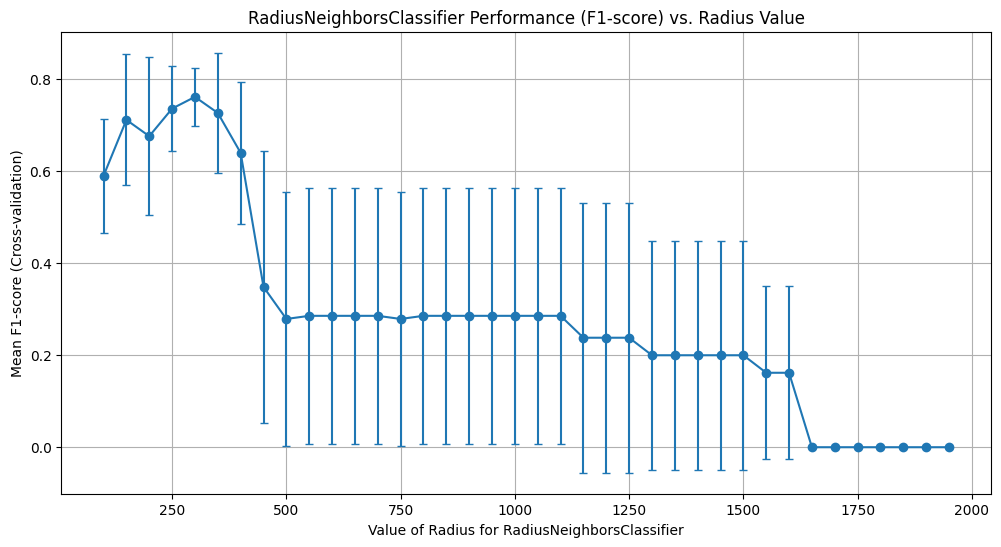

In [43]:
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier

# Define the radii to test
radii_to_test = range(100, 2000, 50)  # Valores desde el 100 al 1000, incrementando de a 50

# Lists to store the results
radii_values = []
mean_f1_scores_rnn = []
std_f1_scores_rnn = []

# Loop through radius values
for radius in radii_to_test:
  # Initialize RadiusNeighborsClassifier
  rnn = RadiusNeighborsClassifier(radius=radius, outlier_label="most_frequent", metric='l1', weights='uniform')

  # Perform cross-validation with 7 folds on the pre-processed data
  cv_scores_rnn = cross_val_score(rnn, X_train_processed, y_train, cv=7, scoring="f1", n_jobs=-1)

  # Store the results
  radii_values.append(radius)
  mean_f1_scores_rnn.append(cv_scores_rnn.mean())
  std_f1_scores_rnn.append(cv_scores_rnn.std())

  # Report f1 score for the current radius
  print(f"Radius={radius}: F-score = {cv_scores_rnn.mean():0.3f} ± {cv_scores_rnn.std():0.3f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.errorbar(radii_values, mean_f1_scores_rnn, yerr=std_f1_scores_rnn, marker='o', linestyle='-', capsize=3)
plt.xlabel("Value of Radius for RadiusNeighborsClassifier")
plt.ylabel("Mean F1-score (Cross-validation)")
plt.title("RadiusNeighborsClassifier Performance (F1-score) vs. Radius Value")
plt.grid(True)
plt.show()

In [ ]:
from scikit.m

#  ¿Podríamos haber tomado otras decisiones?
Hasta ahora, seguimos una secuencia de pasos razonable: primero elegimos la mejor normalización (manteniendo los demás parámetros fijos), luego seleccionamos la mejor estrategia para reducir a 14 atributos (sobre esa normalización), y por último, buscamos los mejores hiperparámetros para KNN.

## Ejercicio:

¿Creen que esta forma de avanzar garantiza encontrar la mejor combinación posible?
¿En qué puntos podríamos haber hecho las cosas de otra manera o de forma más completa?

Justifique brevemente

# Pipelines!

Un Pipeline en scikit-learn nos permite encadenar múltiples pasos del procesamiento de datos (como escalado, selección de atributos, y entrenamiento del modelo) en un único objeto. Esto facilita la organización del código, evita errores comunes y mejora la reproducibilidad de los experimentos.

¿Por qué usar Pipelines?
📦 Todo en uno: Agrupan preprocesamiento, selección de atributos y modelado en un solo flujo.

🔄 Facilita la validación cruzada: Nos aseguramos de que todos los pasos se hagan dentro de cada partición de la validación, evitando fugas de información (data leakage).

🔍 Permiten búsqueda de hiperparámetros conjunta: Se puede hacer búsqueda automática (GridSearchCV, RandomizedSearchCV) sobre todas las partes del pipeline, no solo sobre el modelo final.

✅ Reproducible y ordenado: Hace que todo el flujo de procesamiento y entrenamiento sea más claro, robusto y replicable.

In [44]:
from sklearn.pipeline import Pipeline

# Based on the analysis, the best approach was:
# 1. Normalization: StandardScaler (Standardization)
# 2. Feature Selection: SequentialFeatureSelector (SFS forward, selecting 14 features)
# 3. KNN Hyperparameters: Based on the grid search and K value analysis.
#    Let's pick the best found from the grid search, which was n_neighbors=10, weights='uniform', metric='l1'.
#    Note: The K value plot suggested higher values might be better depending on the trade-off with variance.
#    Let's use the best parameters found by GridSearchCV on the SFS-selected features: best_params

# Define the steps of the pipeline
# Step 1: Standardization (applied before SFS)
# Step 2: Sequential Feature Selection (applied after scaling)
# Step 3: KNN Classifier with optimized hyperparameters
pipeline_steps = [
    ('scaler', StandardScaler()),  # Normalization found to be best or comparable
    ('feature_selection', SequentialFeatureSelector(estimator=KNeighborsClassifier(),
                                                    n_features_to_select=14,
                                                    direction='forward',
                                                    cv=7,
                                                    scoring='f1',
                                                    n_jobs=1)), # SFS as feature selection
    ('knn', KNeighborsClassifier(**best_params)) # KNN with best found hyperparameters
]

# Create the pipeline
best_pipeline = Pipeline(pipeline_steps)

cv_scores_sfs = cross_val_score(best_pipeline, X_train_processed, y_train, cv=7, scoring="f1", n_jobs=-1)

print("\nResults with SFS (14 features, forward):")
print(f"F-score: {cv_scores_sfs.mean():0.3f}±{cv_scores_sfs.std():0.3f}")



Results with SFS (14 features, forward):
F-score: 0.802±0.058


### Ejercicio: por qué demora tanto?!
Si estamos corriendo el miso pipe que hasta ahora, pero todo junto, por qué está tardando tanto esta celda? Qué implicancias tiene?

## Busqueda de hyperparametros en Pipes
El objeto `Pipeline` es tambien un estimador, y como tal podemos buscar hiperparametros.

El ejemplo de abajo muestra como hacerlo.

### Ejercico
Ejecutar la celda de abajo (toma algunos minutos).

Registrar la mejor configuración y los resultados.

Hacer una copia de la celda y re-ejecutar la busqueda de hiperparametros, siguiendo Grid o Random search para buscar una mejor connfiguración.

_Cuidado: como vimos, el pipeline demora más en ejecutar, de manera que hacer pruebas validando cada punto del pipe es también costoso._

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Placeholder, will be replaced by scaler in param_grid
    ('feature_selection', SelectKBest()), # Placeholder for feature selection method
    ('knn', KNeighborsClassifier(weights='uniform'))
])

# Definir el espacio de búsqueda de parámetros para GridSearchCV
param_grid = {
    # Estrategias de estandarización: MinMaxScaler o StandardScaler
    'scaler': [MinMaxScaler(), StandardScaler(), None], # None para no probar nada

    # Estrategias de selección de features: SelectKBest, RFE, SequentialFeatureSelector
    'feature_selection': [
        SelectKBest(k=7,score_func=f_classif),
        RFE(n_features_to_select=7, estimator=DecisionTreeClassifier(random_state=42), step=1), # Estimador para RFE, step=1 elimina una feature por iteración
        RFE(n_features_to_select=14, estimator=DecisionTreeClassifier(random_state=42), step=1), # Estimador para RFE, step=1 elimina una feature por iteración
        RFE(n_features_to_select=15, estimator=DecisionTreeClassifier(random_state=42), step=1), # Estimador para RFE, step=1 elimina una feature por iteración
        SequentialFeatureSelector(n_features_to_select=7, estimator=KNeighborsClassifier(), direction='forward', cv=3, scoring='f1', n_jobs=1), # Estimador para SFS
    ],
    'feature_selection__n_features_to_select': [7,14,21],

    # Parámetros del clasificador KNN
    'knn__n_neighbors': [3, 5, 7], # Cantidad de vecinos a usar
    # 'knn__weights': ['uniform', 'distance'], # Peso de los vecinos
    # 'knn__metric': ['euclidean', 'manhattan', "cosine"] # Métrica de distancia
}

grid_search_pipeline = GridSearchCV(estimator=pipeline,
                                    param_grid=param_grid,
                                    cv=7,
                                    scoring='f1',
                                    n_jobs=-1, # Usar todos los cores para las combinaciones externas
                                    verbose=2) # Para ver el progreso

# Ejecutamos la Grid Search en los datos de entrenamiento procesados (antes de la normalización y selección)
# El pipeline se encargará de aplicar la normalización y la selección dentro de cada fold de CV.
grid_search_pipeline.fit(X_train_processed, y_train)

# Obtenemos los mejores parámetros encontrados
best_params_pipeline = grid_search_pipeline.best_params_

# Obtenemos el mejor score (media de F1-score en cross-validation)
best_score_pipeline = grid_search_pipeline.best_score_

# Calculamos el error estándar de la mejor configuración
std_best_score_pipeline = grid_search_pipeline.cv_results_['std_test_score'][grid_search_pipeline.best_index_]


print("\nResultados de la Grid Search sobre el Pipeline:")
print("Mejores parámetros encontrados:")
print(best_params_pipeline)
print("\nMejor score (Media F1-score en CV) con los mejores parámetros:")
print(f"F-score: {best_score_pipeline:0.3f}±{std_best_score_pipeline:0.3f}")

In [ ]:
# copien aca la celda anterior y modifiquenla segun crean conveniente.
# El objetivo en este punto es encontrar los mejores valores posibles

# Hora del Test-set!
Hora de la evaluacion final!

- Instanciar el mejor modelo logrado hasta el momento, con los mejores parametros
- Entrenarlo con todos los datos de entrenamiento
- Predecir sobre el conjunto de test

In [ ]:

best_model = grid_search_pipeline.best_estimator_

best_model.fit(X_train_processed, y_train)
y_pred = best_model.predict(X_test_processed)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Por ultimo vemos la matriz de confusion:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Ejercicio
Compare la performance obtenida por validación cruzada para arboles, en el practico pasado. Justifique.